**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/msgtsuzuki/saved_models/blob/main/tutorial04/Tutorial04-N.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/msgtsuzuki/saved_models/blob/main/tutorial04/Tutorial04-N.ipynb)   


# Tutorial 4: Inception, ResNet and DenseNet

This tutorial will focus on implementing and examining variations of contemporary CNN architectures. Over the last few years, several architectures have been introduced, some of the most influential and enduring being [GoogleNet Inception](https://arxiv.org/abs/1409.4842) architecture (the winner of ILSVRC 2014), [ResNet](https://arxiv.org/abs/1512.03385) (the winner of ILSVRC 2015) and [DenseNet](https://arxiv.org/abs/1608.06993) (recipient of the best paper award at CVPR 2017). These models were cutting-edge at the time of their introduction, and their fundamental concepts form the basis for many current state-of-the-art architectures. Thus, it is essential to dive into these architectures comprehensively and grasp how to put them into practice. The process begins with the import of the standard libraries.

In [20]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

The same `set_seed` function will be used as in the previous tutorials, as well as the path variables `DATSET_PATH` and `CHEKPOINT_PATH`.

In [21]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Pretrained models and Tensorboards (further details on this will be provided later) for this tutorial are accessible and can be obtained as shown below.

In [22]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://github.com/msgtsuzuki/saved_models/raw/main/tutorial04/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Throughout this tutorial, the models will be trained and evaluated on the CIFAR10 dataset. This allows one to compare the results obtained here with the model they have implemented in the first assignment. As has been learned from the previous tutorial on initialization, it is important to have the data preprocessed with a zero mean. Therefore, as a first step, the mean and standard deviation of the CIFAR dataset will be calculated:

In [23]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


This information is utilized to define a `transforms.Normalize` module which normalizes data accordingly. Additionally, data augmentation is employed during training to mitigate the risk of overfitting and improve the generalization capabilities of CNNs. Specifically, two random augmentations are applied.

First, each image is flipped horizontally with a 50\% probability using `transforms.RandomHorizontalFlip`. The object class typically remains unchanged when an image is flipped and image information is not anticipated to rely on horizontal orientation. However, this might differ if the task involved detecting digits or letters in an image, given their specific orientation.

Second, the augmentation known as `transforms.RandomResizedCrop` is utilized. This transformation crops the image within a minor range, potentially altering the aspect ratio, and then scales it back to its original size. As a result, while the actual pixel values are altered, the content or overall semantics of the image remains consistent.

The training dataset is randomly divided into a training set and a validation set. The validation set serves the purpose of determining early stopping. Upon completion of training, the models are evaluated on the CIFAR test set.

In [24]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


To verify the effectiveness of normalization, printing out the mean and standard deviation of a single batch is conducted. The mean is expected to be close to 0 and the standard deviation close to 1 for each channel:

In [25]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Finally, visualization of a few images from the training set and their appearance after random data augmentation is conducted:

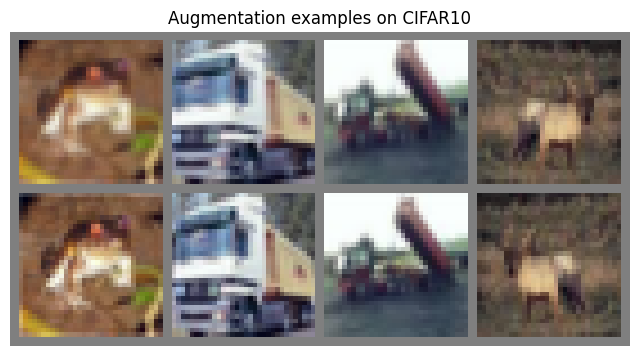

In [26]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## PyTorch[ Lightning]

In this notebook and many subsequent ones, the library [`PyTorch Lightning`](https://www.pytorchlightning.ai/) is utilized. `PyTorch Lightning` is a framework that streamlines the code necessary for trainin[g, evaluating, and ]testing a model in PyTorch. It facilitates logging into [`TensorBoard`](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), a visualization toolkit for machine learning experiments, and automates the saving of model checkpoints with minimal code overhead. This proves immensely beneficial for focusing on the implementation of different model architectures while minimizing time spent on other coding tasks. It is noted that at the time of writing/teaching, the framework has been released in version 1.8. Future versions may present a slightly altered interface, potentially affecting compatibility with the code (efforts will be made to keep it as up-to-date aspossible).

The first step with `PyTorch Lightning` is undertaken, and the exploration of the framework will continue in other tutorials. The library is imported as the initial step:

In [27]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:

In [28]:
# Setting the seed
pl.seed_everything(42)

Seed set to 42


42

Thus, in the future, the definition of a custom `set_seed` function becomes unnecessary.

In `PyTorch Lightning`, `pl.LightningModule`s (inheriting from `torch.nn.Module`) are defined, organizing code into five main sections:

*  Initialization (`__init__`), where all necessary parameters/models are created.
*  Optimizers (`configure_optimizers`) where optimizers, learning rate schedulers, etc., are created.
*  Training loop (`training_step`) where the loss calculation for a single batch is defined (the loop of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as well as any logging/saving operation, is performed in the background).
*  Validation loop (`validation_step`) where, similar to training, what should happen per step is defined.
*  Test loop (`test_step`) which is analogous to validation, only applied to a test set.

Hence, the PyTorch code is not abstracted but rather organized and some default operations commonly used are defined. If there is a need to modify anything in the training/validation/test loop, numerous functions are available for override (refer to the [`docs`](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) for details).

An example of a Lightning Module for training a CNN is now presented:

In [29]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

The code is organized and clear, which enables comprehension by others.

Another crucial aspect of `PyTorch Lightning` involves the concept of callbacks. Callbacks are self-contained functions embodying the non-essential logic of the Lightning Module. They are typically invoked upon completing a training epoch, but they can also impact other segments of the training loop. For example, the use of two predefined callbacks, `LearningRateMonitor` and `ModelCheckpoint`, is planned. The `LearningRateMonitor` adds the current learning rate to TensorBoard, helping to verify the effective operation of the learning rate scheduler. The `ModelCheckpoint` callback permits customization of the checkpoint saving routine, such as the number of checkpoints to retain, the time of saves and which metric to monitor. These are imported as follows:

In [30]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To facilitate the execution of multiple different models with the same Lightning module, a function is defined below that maps a model name to the model class. At this stage, the dictionary `model_dict` is empty, but it will be populated throughout the notebook with new models.

In [31]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Similarly, to treat the activation function as another hyperparameter in the model, a "name to function" dictionary is defined below:

In [32]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

If classes or objects are passed directly as an argument to the Lightning module, the automatic hyperparameter saving and loading feature of `PyTorch Lightning` could not be used.

Beyond the Lightning module, the Trainer constitutes the second pivotal module within `PyTorch Lightning`. The trainer is tasked with executing the training steps delineated in the Lightning module, thus rounding out the framework. Analogously to the Lightning module, any key component deemed unsuitable for automation can be overridden, though default settings frequently represent best practices. For a complete overview, refer to [`documentation`](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html). The principal functions used are as follows:

* `trainer.fit`: Accepts a Lightning module, a training dataset, and an (optional) validation dataset as inputs. This function trains the provided module on the training dataset, with occasional validation (by default once per epoch, though this can be modified).
* `trainer.test`: Receives a model and a dataset for testing purposes. It outputs the test metric for the dataset.

For training and testing, concerns such as setting the model to eval mode (`model.eval()`) are managed automatically. The definition of a training function for the models is illustrated below.


In [33]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Finally, focus is shifted to the Convolutional Neural Networks planned for this tutorial: GoogleNet, ResNet, and DenseNet.

## Inception

The [`GoogleNet`](https://arxiv.org/abs/1409.4842), introduced in 2014, clinched the ImageNet Challenge through its implementation of Inception modules. The focus within this tutorial predominantly lies on the Inception concept rather than the specifics of GoogleNet, as Inception has spurred numerous subsequent developments [`Inception-v2`](https://arxiv.org/abs/1512.00567), [`Inception-v3`](https://arxiv.org/abs/1512.00567), [`Inception-v4`](https://arxiv.org/abs/1602.07261), [`Inception-ResNet`](https://arxiv.org/abs/1602.07261), etc. These developments chiefly aim at enhancing efficiency and facilitating the construction of very deep Inception networks. Nonetheess, for a foundational comprehension, examining the riginal Inception block suffices.

An Inception bl[ck oncurrently executes four convolutional operations on an identical feature map: $1 \times 1$, $3 \times 3$, and $5 \times 5$ convolutions, along with a max pooling operation. This arrangement enables the network to analyze the same data through different receptive fields. Although a sole reliance on $5 \times 5$ convolutions could theoretically offer greater capability, it significantly increases both computation and memory demands and increases the risk of overfitting. The general Inception block is depicted as follows (figure credit - [Szegedy et al.](https://arxiv.org/abs/1409.4842)):

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/inception_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The inclusion of $1 \times 1$ convolutions prior to the $3 \times 3$ and $5 \times 5$ convolutions serves the purpose of dimensionality reduction. This step is particularly vital because the feature maps from all branches are combined subsequently, and an explosion in feature size is undesirable. Given that 5x5 convolutions are 25 times more computationally intensive than 1x1 convolutions, a significant reduction in computation and parameters can be achieved by decreasing the dimensionality before undertaking the larger convolutions.

An attempt is now made to implement the Inception Block independently.

In [34]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

The `GoogleNet` architecture is characterized by the sequential arrangement of multiple Inception blocks, interspersed with occasional max-pooling to diminish the height and width of the feature maps. Originally tailored for the image dimensions of ImageNet ($224 \times 224$ pixels), the original `GoogleNet` encompassed nearly 7 million parameters. Given that training in CIFAR10 involves images of $32 \times 32$ size, a less complex architecture is used instead, featuring a reduced version. The details, such as the number of channels for dimensionality reduction and the output per filter ($1 \times 1$, $3 \times 3$, $5 \times 5$, and max pooling), are subject to manual specification and can be adjusted as desired. It is generally advised to allocate the majority of filters to the $3 \times 3$ convolutions, considering their efficiency in contextual processing while consuming roughly a third of the parameters required by the 5x5 convolution.

In [35]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Now, the model can be integrated into the model dictionary that was defined previously:

In [36]:
model_dict["GoogleNet"] = GoogleNet

The training of the model is facilitated by `PyTorch Lightning`, necessitating only the definition of the command to initiate the process. It is noteworthy that the training extends for approximately 200 epochs, a duration which amounts to less than an hour on Snellius's standard GPUs (NVIDIA A100). Utilization of saved models is recommended, and personal model training is encouraged for those interested.

In [82]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet",
                                                 model_hparams={"num_classes": 10,
                                                                "act_fn_name": "relu"},
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/tutorial4\GoogleNet.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Disciplinas\DeepLearning\saved_models\tutorial4\GoogleNet.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

The results will be compared later in the notebooks, but they can already be printed here for an initial overview:

In [83]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8969999551773071, 'val': 0.9039999842643738}


### Tensorboard log

An advantageous feature of `PyTorch Lightning` includes automatic log-in to TensorBoard. For a clearer understanding of TensorBoard's applications, examination of the board generated by `PyTorch Lightning` during GoogleNet training is possible. TensorBoard offers inline functionality for Jupyter notebooks, which is utilized here:

In [2]:
# Load tensorboard extension
%load_ext tensorboard

In [11]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tutorial4/tensorboards/GoogleNet/

Reusing TensorBoard on port 6006 (pid 15560), started 5:33:24 ago. (Use '!kill 15560' to kill it.)

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/tensorboard_screenshot_GoogleNet.png" width="1000px"></center>

TensorBoard features organization across multiple tabs, with the scalar tab being a principal focus where the evolution of singular metrics is logged. For instance, training loss, accuracy, learning rate, etc., have been charted. Observing training or validation accuracy underscores the importance of employing a learning rate scheduler, where a reduction in the learning rate markedly enhances training performance. Similarly, a noticeable drop in training loss is observed at this point. However, elevated figures in the training set relative to validation suggest overfitting, a common occurrence in expansive networks.

Another tab of interest within TensorBoard is the graph tab, which delineates the network architecture, arranged by building blocks from input to output. Essentially, it illustrates the operations conducted during the forward step of `CIFARModule`. Double clicking on a module opens up, offering an invitation to explore the architecture from a novel angle. The visual representation of the graph aids in verifying that the model functions as intended, ensuring that no layers are omitted in the computation graph.

## ResNet

The [ResNet paper](https://arxiv.org/abs/1603.05027) is one of the most cited AI papers and has been the foundation for neural networks with more than 1,000 layers. Despite its simplicity, the idea of residual connections is highly effective, as it supports stable gradient propagation through the network. Instead of modeling $x_{l+1}=F(x_{l})$, the model $x_{l+1}=x_{l}+F(x_{l})$ is used, where $F$ is a nonlinear mapping (usually a sequence of NN modules like convolutions, activation functions, and normalizations). If backpropagation is performed on such residual connections, the result is
$$
\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}.
$$
The bias towards the identity matrix guarantees a stable gradient propagation that is less affected by $F$ itself. Many variants of ResNet have been proposed, mainly pertaining to the function $F$, or operations applied on the sum. In this tutorial, two of them are examined: the original ResNet block and the Pre-Activation ResNet block. The blocks are visually compared below:

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/resnet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="300px"/></center>

The original ResNet block applies a nonlinear activation function, usually ReLU, after the skip connection. In contrast, the preactivation ResNet block applies the nonlinearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep networks, however, the preactivation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it. For comparison, in this notebook, both ResNet types are implemented as shallow networks.

Starting with the original ResNet block, the above visualization already shows which layers are included in $F$. One special case that needs to be handled is when the image dimensions in terms of width and height need to be reduced. The basic ResNet block requires $F(x_{l})$ to be of the same shape as $x_{l}$. Thus, the dimensionality of $x_{l}$ should also be changed before adding to $F(x_{l})$. The original implementation used an identity mapping with stride 2 and padded additional feature dimensions with 0. However, the more common implementation is to use a $1 \times 1$ convolution with stride 2 as it allows changing the dimensionality of the feature while being efficient in parameter and computation cost. The code for the ResNet block is relatively simple and is shown below:

In [41]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

The second block implemented is the ResNet pre-activation block. For this, the order of the layers in `self.net` needs to be changed, and no activation function is applied on the output. Additionally, the downsampling operation has to apply a nonlinearity, as well as the input, $x_l$, has not been processed by a non-linearity yet. Hence, the block looks as follows:

In [42]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )

        # 1x1 convolution can apply non-linearity as well, but not strictly necessary
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

Similarly to model selection, a dictionary is defined to create a mapping from string to block class. The string name is used as a hyperparameter value in the model to choose between the ResNet blocks. Any other ResNet block type can also be implemented and added here.

In [43]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

The overall ResNet architecture consists of stacking multiple ResNet blocks, some of which are downsampling the input. When referring to ResNet blocks in the whole network, they are usually grouped by the same output shape. For example, by saying that ResNet has `[3,3,3]` blocks, it means that there are 3 groups of 3 ResNet blocks, where subsampling takes place in the fourth and seventh blocks.  ResNet with `[3,3,3]` blocks on CIFAR10 is visualized below.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/resnet_notation.svg" width="500px"></center>

The three groups operate at resolutions $32 \times 32$, $16 \times 16$, and $8 \times 8$, respectively. The blocks in orange denote ResNet blocks with downsampling. The same notation is used by many other implementations such as in the [torchvision library](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18) from PyTorch. Thus, the code looks as follows:

In [44]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs:
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       c_hidden=c_hidden,
                                       num_blocks=num_blocks,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

The new ResNet class also needs to be added to the model dictionary:

In [45]:
model_dict["ResNet"] = ResNet

Finally, the ResNet models can be trained. One difference from GoogleNet training is that SGD with Momentum is explicitly used as an optimizer instead of Adam. Adam often leads to slightly worse accuracy on plain, shallow ResNets. The reason for this is not entirely clear, but one possible explanation is related to ResNet's loss surface. ResNet has been shown to produce smoother loss surfaces than networks without skip connections (see [Li et al., 2018](https://arxiv.org/pdf/1712.09913.pdf) for details). A possible visualization of the loss surface with/without skip connections is given below.

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial4/resnet_loss_surface.svg" style="display: block; margin-left: auto; margin-right: auto;" width="600px"/></center>

The $x$ and $y$ axes show a projection of the parameter space, and the $z$ axis shows the loss values achieved by different parameter values. On smooth surfaces like the one on the right, an adaptive learning rate may not be required, as Adam provides. Instead, Adam can get stuck in local optima while SGD finds the wider minima that tend to generalize better.
However, to answer this question in detail, an additional tutorial would be needed because it is not easy to answer. For now, the conclusion is as follows: for ResNet architectures, consider the optimizer to be an important hyperparameter and try training with both Adam and SGD. The model can be trained below with SGD:

In [46]:
resnet_model, resnet_results = train_model(model_name="ResNet",
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"},
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Disciplinas\DeepLearning\saved_models\tutorial4\ResNet.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial4\ResNet.ckpt, loading...


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

The preactivation ResNet is also trained as a comparison:

In [47]:
resnetpreact_model, resnetpreact_results = train_model(model_name="ResNet",
                                                       model_hparams={"num_classes": 10,
                                                                      "c_hidden": [16,32,64],
                                                                      "num_blocks": [3,3,3],
                                                                      "act_fn_name": "relu",
                                                                      "block_name": "PreActResNetBlock"},
                                                       optimizer_name="SGD",
                                                       optimizer_hparams={"lr": 0.1,
                                                                          "momentum": 0.9,
                                                                          "weight_decay": 1e-4},
                                                       save_name="ResNetPreAct")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/tutorial4\ResNetPreAct.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Disciplinas\DeepLearning\saved_models\tutorial4\ResNetPreAct.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

### Tensorboard log

Similarly to the GoogleNet model, there is also a TensorBoard log for the ResNet model. It can be opened in the following.

In [48]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tutorial4/tensorboards/ResNet/

Reusing TensorBoard on port 6007 (pid 5292), started 4:50:23 ago. (Use '!kill 5292' to kill it.)

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/tensorboard_screenshot_ResNet.png" width="1000px"></center>

Feel free to explore the TensorBoard, including the computation graph. In general, it can be observed that with SGD, ResNet has a higher training loss than GoogleNet in the first stage of training. After reducing the learning rate, however, the model achieves even higher validation accuracies. The precise scores at the end of the notebook are compared.

## DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993) is another architecture to enable very deep neural networks and takes a slightly different perspective on residual connections. Instead of modeling the difference between layers, DenseNet considers residual connections as a possible way to reuse features across layers, removing any need to learn redundant feature maps. When going deeper into the network, the model learns abstract features to recognize patterns. However, some complex patterns consist of a combination of abstract features (e.g. hand, face, etc.) and low-level features (e.g., edges, basic color, etc.). To find these low-level features in the deep layers, standard CNNs have to learn to copy such feature maps, which wastes a lot of parameter complexity. DenseNet provides an efficient way of reusing features by having each convolution depend on all previous input features, but adds only a small amount of filters to it. See [Figure](https://arxiv.org/abs/1608.06993) for an illustration:

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/densenet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The last layer, called the transition layer, is responsible for reducing the dimensionality of the feature maps in height, width, and channel size. Although those technically break the identity backpropagation, there are only a few in a network so that it does not affect the gradient flow much.

The implementation of layers in DenseNet is split into three parts: a `DenseLayer`, a `DenseBlock`, and a `TransitionLayer`. The module `DenseLayer` implements a single layer inside a dense block. It applies a $1 \times 1$ convolution for dimensionality reduction with a subsequent $3 \times 3$ convolution. The output channels are concatenated into the originals and returned. Note that Batch Normalization is applied as the first layer of each block, allowing slightly different activations for the same features to different layers, depending on what is needed. In general, it can be implemented as follows.

In [49]:
class DenseLayer(nn.Module):

    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

The module `DenseBlock` summarizes multiple dense layers applied in sequence. Each dense layer takes as input the original input concatenated with all previous layers' feature maps:

In [50]:
class DenseBlock(nn.Module):

    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

Finally, the `TransitionLayer` takes as input the final output of a dense block and reduces its channel dimensionality using a $1 \times 1$ convolution. To reduce the height and width dimension, a slightly different approach is taken than in ResNet, applying average pooling with kernel size 2 and stride 2. This is because there is no additional connection to the output that would consider the entire $2 \times 2$ patch instead of a single value. Besides, it is more parameter-efficient than using a $3 \times 3$ convolution with stride 2. Thus, the layer is implemented as follows.

In [51]:
class TransitionLayer(nn.Module):

    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)

Now, everything can be put together to create DenseNet. To specify the number of layers, a similar notation as in ResNets is used, passing on a list of ints representing the number of layers per block. After each dense block except the last one, a transition layer is applied to reduce the dimensionality by 2.

In [52]:
class DenseNet(nn.Module):

    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels

        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )

        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(c_in=c_hidden,
                           num_layers=num_layers,
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

The DenseNet is also added to the model dictionary:

In [53]:
model_dict["DenseNet"] = DenseNet

Lastly, the network can be trained. In contrast to ResNet, DenseNet does not show any issues with Adam, and hence it is trained with this optimizer. The other hyperparameters are chosen to result in a network with a parameter size similar to that of ResNet and GoogleNet. Commonly, when designing very deep networks, DenseNet is more parameter-efficient than ResNet, while achieving a similar or even better performance.

In [54]:
densenet_model, densenet_results = train_model(model_name="DenseNet",
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"},
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Disciplinas\DeepLearning\saved_models\tutorial4\DenseNet.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial4\DenseNet.ckpt, loading...


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

### Tensorboard log

Finally, another TensorBoard for DenseNet training is available. It can be explored in the following:

In [55]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tutorial4/tensorboards/DenseNet/

Reusing TensorBoard on port 6008 (pid 5664), started 4:48:26 ago. (Use '!kill 5664' to kill it.)

<center width="100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial04/tensorboard_screenshot_DenseNet.png" width="1000px"></center>

The overall course of the validation accuracy and training loss resemble that of GoogleNet, which is also related to the training of the network with Adam. Feel free to explore the training metrics.

## Conclusion and Comparison

After discussing each model separately and training all of them, the results can finally be compared. First, let us organize the results of all models in a table:

In [56]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [57]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    ("DenseNet", densenet_results, densenet_model)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
GoogleNet,90.40%,89.70%,"260,650"
ResNet,91.84%,91.06%,"272,378"
ResNetPreAct,91.80%,91.07%,"272,250"
DenseNet,90.72%,90.23%,"239,146"


All models perform reasonably well. Simple models achieve considerably lower performance, attributed to the architecture design choice. GoogleNet obtains the lowest performance in the validation and test set, although it is very close to DenseNet. A proper hyperparameter search over all the channel sizes in GoogleNet would likely improve the accuracy of the model to a similar level, but this is also expensive given the large number of hyperparameters. ResNet outperforms both DenseNet and GoogleNet by more than 1\% on the validation set, while there is a minor difference between both versions, original and preactivation. For shallow networks, the place of the activation function does not seem to be crucial, although papers have reported the contrary for [very deep networks](https://arxiv.org/abs/1603.05027).

In general, it can be concluded that `ResNet` represents a straightforward yet effective architecture. Applying the models to more complex tasks with larger images and additional layers within the networks is likely to reveal a more pronounced disparity between `GoogleNet` and skip-connection architectures like `ResNet` and `DenseNet`. For example, a comparison with deeper models on `CIFAR10` can, for ex[ample, be [found](https://github.com/kuangliu/pytorch-cifar). In particular, `DenseNet` surpasses the original `ResNet` in their setup but narrowly trails behind Pre-Activation `ResNet`. The optimal model, a [dual-path network](https://arxiv.org/abs/1707.01629), merges `ResNet` and `DenseNet`, illustrating that both architectures bring distinct benefits.

### Which model should be chosen for a given task?

Four different models have been examined. Thus, the question arises: which should be selected for a new task? Generally, starting with `ResNet` is advisable, given its superior performance on the `CIFAR` dataset and its straightforward implementation. Moreover, for the number of parameters selected herein, `ResNet` operates the quickest, as `DenseNet` and `GoogleNet` incorporate many more layers, which are applied sequentially in a basic implementation. However, for particularly challenging tasks, such as semantic segmentation on HD images, more intricate variants of `ResNet` and `DenseNet` are advocated.